# Consultas Integradas

Este notebook tiene el fin de generar las consultas planteadas en el trabajo práctico integrador

## Importación librerias

Se importan las librerias necesarias para la ejecución de las distintas consignas.

In [80]:
import os
from pathlib import Path
import pandas as pd
from pymongo.errors import ConnectionFailure
from db_connections import client, db_neo4j, db_redis
from src import mongo, neo4j, utils, redis
from IPython.display import display
import matplotlib.pyplot as plt
from constants import NOMBRE_BD_MONGO
import seaborn as sns

# PABLO BORRAR EL SIGUIENTE CODIGO UNA VEZ QUE TERMINES

In [81]:
# =====================
# TEST DE CONEXIONES
# =====================

#Conecto con MongoDB
try:
    client.admin.command("ping")  # fuerza conexión al servidor
    print("✅ Conexión a MongoDB verificada.")
except ConnectionFailure as e:
    print(f"❌ Falló la conexión: {type(e).__name__} - {e}")

#Conecto con Neo4j
try:
    db_neo4j.verify_connectivity()
    print("✅ Conexión a Neo4j verificada.")
except Exception as e:
    print(f"❌ Error de conexión: {type(e).__name__} - {e}")

#Conecto con Redis
try:
    db_redis.ping()
    print("✅ Conexión a Redis verificada.")
except Exception as e:
    print(f"❌ Error de conexión: {type(e).__name__} - {e}")

✅ Conexión a MongoDB verificada.
✅ Conexión a Neo4j verificada.
✅ Conexión a Redis verificada.


## 1. Consultas

### A. Mostrar los usuarios que visitaron “Bariloche”. 

In [82]:
query = """ 
MATCH (U:Usuario)-[:VISITO]->(D:Destino)
WHERE D.ciudad='Bariloche'
RETURN U.nombre AS Nombre, U.apellido AS Apellido
"""

usuarios = neo4j.consulta(db_neo4j, query)

print("\n" + "-"*60)
print("USUARIOS QUE VISITARON BARILOCHE")
print("-"*60)
display(usuarios.style.hide(axis="index"))


------------------------------------------------------------
USUARIOS QUE VISITARON BARILOCHE
------------------------------------------------------------


Nombre,Apellido
Tito,Montserrat
Gema,Yáñez
Leopoldo,Agudo
Carmen,Roma
Lucas,Cruz
Georgina,Talavera
Calista,Catalán
Graciana,Murillo
Adrián,Belda
Juan José,Romero


### B. Mostrar los amigos de Juan que visitaron algún destino que visitó él, mostrar el nombre del Usuario y el destino. 

In [83]:
# Pedimos el nombre del usuario
nombre_usuario = input("Introduce tu nombre para saber qué lugares visitaste con tus amigos: ")

query = """
MATCH (u:Usuario)
WHERE toLower(u.nombre) CONTAINS toLower($nombre)
MATCH (u)-[:AMIGO_DE]-(amigo:Usuario)
MATCH (u)-[:VISITO]->(d:Destino)<-[:VISITO]-(amigo)
RETURN 
    amigo.nombre AS Nombre,
    collect(DISTINCT d.ciudad) AS Destinos_Compartidos
ORDER BY Nombre
"""

#Encabezado
print("\n" + "-"*60)
print(f"{nombre_usuario.upper()} TUS AMIGOS VISITARON ESTOS MISMOS DESTINOS QUE TÚ")
print("-"*60 + "\n")

# Ejecutamos la consulta usando la función consulta() que devuelve un DataFrame
usuarios = neo4j.consulta(db_neo4j, query, parametros={"nombre": nombre_usuario})

# Convertimos listas a texto legible
usuarios["Destinos_Compartidos"] = usuarios["Destinos_Compartidos"].apply(
    lambda lista: ", ".join(lista) if isinstance(lista, list) else lista
)

# Mostramos el resultado
if usuarios.empty:
    print("No se encontraron amigos que hayan visitado los mismos destinos.")
else:
    display(usuarios.style.hide(axis="index"))

Introduce tu nombre para saber qué lugares visitaste con tus amigos:  Juan



------------------------------------------------------------
JUAN TUS AMIGOS VISITARON ESTOS MISMOS DESTINOS QUE TÚ
------------------------------------------------------------



Nombre,Destinos_Compartidos
Ariadna,"Iguazú, Rosario, Ushuaia"
Calista,"Gualeguaychú, San Martín de los Andes, Bariloche, San Juan"
Candela,"Río Cuarto, Santa Rosa, Rosario"
Carmen,"Córdoba, Mendoza, Iguazú, San Martín de los Andes, Bariloche, Ushuaia"
David,"Gualeguaychú, La Rioja, Neuquén, San Juan, Merlo"
Eliseo,"Villa Carlos Paz, Río Cuarto, Santa Rosa, Mendoza, Iguazú, Rosario"
Emiliana,"Santa Rosa, Iguazú, San Juan, Rosario"
Estela,"Río Cuarto, Iguazú, Bariloche, Gualeguaychú, Santiago del Estero"
Feliciano,"Neuquén, San Martín de los Andes, Bariloche, San Juan, Ushuaia"
Fernanda,"La Rioja, Neuquén, Bariloche, San Juan"


### C. Sugerir destinos a un usuario que no haya visitado él ni sus amigos. 

In [84]:
nombre_usuario = input("Introduce tu nombre para saber qué lugares nuevos que no visitaste ni tu ni tus amigos: ")

query = """
MATCH (u:Usuario)
WHERE toLower(u.nombre) CONTAINS toLower($nombre)
MATCH (d:Destino)
WHERE 
  NOT EXISTS { MATCH (d)<-[:VISITO]-(u) } AND
  NOT EXISTS { MATCH (d)<-[:VISITO]-(u)-[:AMIGO_DE]-(amigo) }
RETURN DISTINCT d.ciudad AS Destinos_No_Visitados
ORDER BY d.ciudad
"""

print("\n" + "-"*60)
print(f"DESTINOS NUEVOS PARA {nombre_usuario.upper()} Y SUS AMIGOS")
print("-"*60 + "\n")

destinos = neo4j.consulta(db_neo4j, query, parametros={"nombre": nombre_usuario})

if destinos.empty:
    print("No hay destinos nuevos disponibles.")
else:
    # Mostrar cada destino en lista
     display(destinos.style.hide(axis="index"))

Introduce tu nombre para saber qué lugares nuevos que no visitaste ni tu ni tus amigos:  Juan



------------------------------------------------------------
DESTINOS NUEVOS PARA JUAN Y SUS AMIGOS
------------------------------------------------------------



Destinos_No_Visitados
Bariloche
CABA
Chilecito
Concordia
Corrientes
Córdoba
El Calafate
Formosa
Gualeguaychú
Iguazú


### D. Recomendar destinos basados en viajes de amigos.

In [87]:
nombre_usuario = input("Introduce tu nombre para saber qué lugares te recomendamos: ")

query = """
MATCH (u:Usuario)
WHERE toLower(u.nombre) CONTAINS toLower($nombre)
MATCH (u)-[:AMIGO_DE]-(amigo:Usuario)
MATCH (amigo)-[:VISITO]->(d:Destino)
WHERE NOT EXISTS { MATCH (u)-[:VISITO]->(d) } 
RETURN DISTINCT d.ciudad AS Destino_Recomendado
ORDER BY d.ciudad
"""

print("\n" + "-"*60)
print(f"RECOMENDACIONES PARA {nombre_usuario.upper()} EN FUNCIÓN DE SUS AMIGOS")
print("-"*60 + "\n")

destinos = neo4j.consulta(db_neo4j, query, parametros={"nombre": nombre_usuario})

if destinos.empty:
    print("No hay destinos recomendados nuevos para vos.")
else:
    display(destinos.style.hide(axis="index"))

Introduce tu nombre para saber qué lugares te recomendamos:  Juan



------------------------------------------------------------
RECOMENDACIONES PARA JUAN EN FUNCIÓN DE SUS AMIGOS
------------------------------------------------------------



Destino_Recomendado
Bariloche
CABA
Chilecito
Concordia
Corrientes
Córdoba
El Calafate
Formosa
Gualeguaychú
Iguazú


### E. Listar los hoteles en los destinos recomendados del punto anterior. 

In [88]:
coleccion = "hoteles"

# Lista de destinos recomendados
lista_destinos = destinos["Destino_Recomendado"].dropna().unique().tolist()

if not lista_destinos:
    print("No hay destinos recomendados disponibles.")
else:
    filtro = {"ciudad": {"$in": lista_destinos}}
    proyeccion = {"_id": 0, "nombre": 1, "ciudad": 1, "direccion": 1}

    # Obtener datos de Mongo y convertir a DataFrame
    cursor = mongo.obtener_cursor(
        NOMBRE_BD_MONGO,
        nombre_coleccion=coleccion,
        filtro=filtro,
        proyeccion=proyeccion
    )

    hoteles = pd.DataFrame(list(cursor))

    if hoteles.empty:
        print("No se encontraron hoteles en los destinos recomendados.")
    else:
        # Ordenar por ciudad y luego por nombre de hotel
        display(hoteles.style.hide(axis="index"))

nombre,ciudad
Hermanos Soria S.Coop. Hotel,La Plata
Espinosa & Asociados S.C.P Hotel,La Plata
Danilo Bas Pérez S.Coop. Hotel,Mar del Plata
Grupo Company S.L.L. Hotel,Mar del Plata
Compañía Hurtado & Asociados S.Coop. Hotel,Mar del Plata
Gonzalez y Yáñez S.Com. Hotel,CABA
Manuel Romeu Mayoral S.Coop. Hotel,CABA
Familia Galiano S.L. Hotel,San Fernando
Compañía Crespo & Asociados S.A. Hotel,San Fernando
Distribuciones VJ S.Coop. Hotel,San Fernando


### F. Ver las reservas en proceso, es decir que aún no están concretadas. 

In [89]:
claves = db_redis.keys("reserva_temp:*")
print(f"Cantidad de reservas en proceso {len(claves)}\n")

if claves:
    cantidad = int(input ("¿Cuántas se desean listar?"))
    print(f"Se imprimen las primeras {cantidad}:")
    for clave in claves[:cantidad]:
        datos = db_redis.hgetall(clave)
        tiempo_restante = db_redis.ttl(clave)
        print(f"{clave}: {datos} | TTL: {tiempo_restante} segundos")

Cantidad de reservas en proceso 404



¿Cuántas se desean listar? 10


Se imprimen las primeras 10:
reserva_temp:89: {'usuario_id': '21', 'destino_id': '3', 'fecha_reserva': '2025-03-07', 'precio_total': '83832'} | TTL: 3412 segundos
reserva_temp:1215: {'usuario_id': '12', 'destino_id': '24', 'fecha_reserva': '2025-04-19', 'precio_total': '73099'} | TTL: 3412 segundos
reserva_temp:517: {'usuario_id': '4', 'destino_id': '10', 'fecha_reserva': '2025-10-15', 'precio_total': '108687'} | TTL: 3412 segundos
reserva_temp:1628: {'usuario_id': '57', 'destino_id': '28', 'fecha_reserva': '2024-11-19', 'precio_total': '66335'} | TTL: 3412 segundos
reserva_temp:949: {'usuario_id': '41', 'destino_id': '17', 'fecha_reserva': '2024-12-19', 'precio_total': '128875'} | TTL: 3412 segundos
reserva_temp:1194: {'usuario_id': '54', 'destino_id': '23', 'fecha_reserva': '2025-04-01', 'precio_total': '88912'} | TTL: 3412 segundos
reserva_temp:291: {'usuario_id': '16', 'destino_id': '7', 'fecha_reserva': '2025-07-18', 'precio_total': '110964'} | TTL: 3412 segundos
reserva_temp:708:

### G. Listar los usuarios conectados actualmente. 

In [ ]:
claves = db_redis.keys("usuario:*:sesion")
print(f"Cantidad de usuarios conectados {len(claves)}\n")

if claves:
    print("Usuarios:")
    for clave in claves:
        usuario_id = clave.split(":")[1]
        estado = db_redis.get(clave)
        tiempo_restante = db_redis.ttl(clave)
        print(f"Usuario {usuario_id} → sesión: {estado} | TTL: {tiempo_restante} segundos")

### H. Mostrar los destinos con precio inferior a $100.000

In [90]:
precio=100000
coleccion = "destinos"
filtro={"precio_promedio": {"$lt": precio}}
proyeccion = {"_id":0}

# Busca en caché y sino consulta en MongoDB
resultado = redis.obtener_cache(coleccion, filtro)
if resultado is None:
    print("Consulta hecha en Mongo")
    resultado = list(mongo.obtener_cursor(NOMBRE_BD_MONGO,coleccion,filtro=filtro,proyeccion=proyeccion))
    if resultado:
        redis.guardar_en_cache(coleccion,filtro,resultado,ttl=300)
else:
    print("Consulta hecha en Redis")
        
df = pd.DataFrame(resultado)
if not df.empty:
    df_ordenado = df.sort_values(by="destino_id")
    display(df_ordenado.style.hide(axis="index"))
else:
    print(f"No existen destinos con precio inferior a {precio}")

Consulta hecha en Mongo


destino_id,provincia,ciudad,pais,tipo,precio_promedio
1,Buenos Aires,La Plata,Argentina,Cultural,56556
3,Ciudad Autónoma de Buenos Aires,CABA,Argentina,Playa,86579
6,Chubut,Puerto Madryn,Argentina,Cultural,57811
9,Córdoba,Río Cuarto,Argentina,Relax,56956
14,Formosa,Formosa,Argentina,Cultural,91853
16,La Pampa,Santa Rosa,Argentina,Montaña,90758
18,La Rioja,Chilecito,Argentina,Cultural,74312
19,Mendoza,Mendoza,Argentina,Aventura,75353
23,Neuquén,Neuquén,Argentina,Relax,82722
24,Neuquén,San Martín de los Andes,Argentina,Aventura,70656


### I. Mostrar todos los Hoteles de “Jujuy”.

In [91]:
coleccion = "hoteles"
ciudad = "San Salvador de Jujuy"
filtro = {"ciudad": ciudad}
proyeccion = {"_id": 0, "nombre": 1, "ciudad": 1, "direccion": 1}

# Busca en caché y sino consulta en MongoDB
resultado = redis.obtener_cache(coleccion, filtro)
if resultado is None:
    print("Consulta hecha en Mongo")
    resultado = list(mongo.obtener_cursor(NOMBRE_BD_MONGO,nombre_coleccion=coleccion,filtro=filtro,proyeccion=proyeccion))
    if resultado:
        redis.guardar_en_cache(coleccion,filtro,resultado,ttl=300)
else:
    print("Consulta hecha en Redis")

df_hoteles = pd.DataFrame(resultado)

if not df_hoteles.empty:
    df_ordenado = df_hoteles.sort_values(by="nombre")
    display(df_ordenado.style.hide(axis="index"))
else:
     print("No se encontraron hoteles en los destinos recomendados.")       

Consulta hecha en Mongo


nombre,ciudad
Comercializadora Soria S.L. Hotel,San Salvador de Jujuy
Manufacturas Puga & Asociados S.L.L. Hotel,San Salvador de Jujuy


### J. Mostrar la cantidad de hoteles de un destino que guste. 

In [ ]:
#Pedimos al usuario el tipo de agrupación y el valor a buscar
agrupar = input("¿Querés agrupar por 'provincia' o 'ciudad'? ").strip().lower()
lugar = input(f"Introduce el nombre de la {agrupar}: ").strip().lower().title()

#Definimos el filtro dinámico según la elección
filtro = {agrupar: lugar}

#Si el usuario elige 'provincia', agrupamos por ciudad dentro de esa provincia
if agrupar == "provincia":
    campo_agrupacion = "ciudad"
else:
    campo_agrupacion = agrupar

#Ejecutamos la función para contar hoteles
cursor = mongo.contador(
    nombre_base=NOMBRE_BD_MONGO,
    coleccion="hoteles",
    agrupacion=campo_agrupacion,
    campo_calculo="hotel_id",
    filtrar=filtro
)

#Convertimos el cursor a DataFrame
hoteles = pd.DataFrame(cursor)

#Mostramos resultados
if agrupar == "provincia":
    print(f"\n📍 Hoteles por ciudad dentro de la provincia {lugar.title()}:\n")
else:
    print(f"\n Cantidad de hoteles en la ciudad {lugar.title()}:\n")

display(hoteles)


¿Querés agrupar por 'provincia' o 'ciudad'?  ciudad
Introduce el nombre de la ciudad:  la plata


La Plata

 Cantidad de hoteles en la ciudad La Plata:



,_id,hotel_id
0,La Plata,2


### K. Mostrar las actividades de “Ushuaia” del tipo “aventura”.

In [92]:
coleccion = "actividades"
tipo="aventura"
ciudad="Ushuaia"
filtro = {"ciudad":ciudad,"tipo":tipo}
proyeccion = {"_id":0}

resultado = redis.obtener_cache(coleccion, filtro)
if resultado is None:
    resultado = list(mongo.obtener_cursor(NOMBRE_BD_MONGO,coleccion,filtro=filtro,proyeccion=proyeccion))
    print("Consulta hecha en Mongo")
    if resultado:
        redis.guardar_en_cache(coleccion,filtro,resultado,ttl=300)
else:
    print("Consulta hecha en Redis")
    
df = pd.DataFrame(resultado)
if not df.empty:
    df_ordenado = df.sort_values(by="actividad_id")
    display(df_ordenado.style.hide(axis="index"))
else:
    print(f"No existen actividades de tipo {tipo} en {ciudad}")

Consulta hecha en Mongo


actividad_id,nombre,tipo,ciudad,provincia,precio
107,Decentralized executive artificial intelligence,aventura,Ushuaia,Tierra del Fuego,33340


### L. Mostrar la cantidad de reservas concretadas de cada usuario. Mostrar el usuario y la cantidad 

In [ ]:
coleccion = "reservas"
estados = ["Confirmada","Pagada"]
filtro = {"estado": {"$in":estados}}

pipeline =[ 
    {"$match": filtro},
    {"$group": {
        "_id": "$usuario_id",  # este es el ID del usuario
        "Reservas_concretadas": {"$sum": 1}
    }},
    {"$lookup": {
        "from": "usuarios",           # nombre de la colección a unir
        "localField": "_id",          # campo en esta colección (el ID del usuario)
        "foreignField": "usuario_id",        # campo en la colección "usuarios"
        "as": "usuario_info"          # nombre del nuevo campo con los datos del usuario
    }},
    {"$unwind": "$usuario_info"},     # desanida el array para acceder directamente
    {"$project": {
        "_id": 0,
        "Nombre": "$usuario_info.nombre",
        "Apellido": "$usuario_info.apellido",
        "Reservas_concretadas": 1
    }},
    {"$sort": {"Reservas_concretadas": -1}}
]

resultado = redis.obtener_cache(coleccion, filtro)
if resultado is None:
    print("Consulta hecha en Mongo")
    resultado = list(client[NOMBRE_BD_MONGO][coleccion].aggregate(pipeline))
    if resultado:
        redis.guardar_en_cache(coleccion,filtro,resultado,ttl=300)
else:
    print("Consulta hecha en Redis")
        
df = pd.DataFrame(resultado)
df = df[["Nombre", "Apellido", "Reservas_concretadas"]]
display(df.style.hide(axis="index"))

## 2.Estadísticas

### I.Destino más visitado

In [159]:
estados = ["Confirmada","Pagada"]
filtro = {"estado": {"$in":estados}}

pipeline =[ 
    {"$match": filtro},
    {"$group": {
        "_id": "$destino_id",  # este es el ID del destino
        "Cantidad_Visitas": {"$sum": 1}
    }},
    {"$lookup": {
        "from": "destinos",           # nombre de la colección a unir
        "localField": "_id",          # campo en esta colección (el ID del destino)
        "foreignField": "destino_id",        # campo en la colección "destino"
        "as": "destino_visitas"          # nombre del nuevo campo con los datos del destino
    }},
    {"$unwind": "$destino_visitas"},     # desanida el array para acceder directamente
    {"$project": {
        "_id": 0,
        "Destino": "$destino_visitas.ciudad",
        "Cantidad_Visitas": 1
    }},
    {"$sort": {"Cantidad_Visitas": -1}},
    {"$limit": 10}
]

resultado = list(client[NOMBRE_BD_MONGO].reservas.aggregate(pipeline))
      
df = pd.DataFrame(resultado)
df = df[["Destino", "Cantidad_Visitas"]]
print("Destino mas vistado")
display(df.style.hide(axis="index"))

Destino mas vistado


Destino,Cantidad_Visitas
Iguazú,46
Viedma,45
San Martín de los Andes,43
San Juan,40
Rosario,39
Bariloche,39
Córdoba,35
Gualeguaychú,34
Río Cuarto,33
San Fernando,31


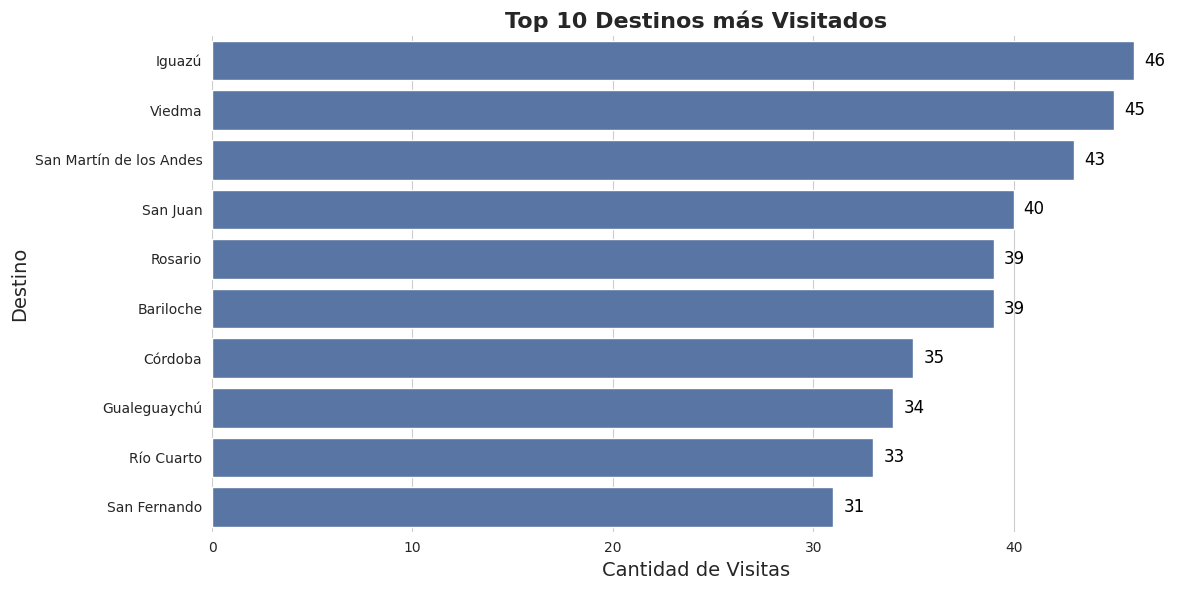

In [160]:
# Ordenar df por Cantidad_Visitas descendente y tomar top 10
df_top10 = df.nlargest(10, "Cantidad_Visitas")

# Azul clásico de Seaborn
azul_sns = sns.color_palette("deep")[0]

plt.figure(figsize=(12, 6))  # más ancho para legibilidad

ax = sns.barplot(
    data=df_top10,
    y="Destino",
    x="Cantidad_Visitas",
    color=azul_sns
)

# Quitar bordes superior y derecho
sns.despine(left=True, bottom=True)

# Títulos y etiquetas
plt.title("Top 10 Destinos más Visitados", fontsize=16, fontweight="bold")
plt.xlabel("Cantidad de Visitas", fontsize=14)
plt.ylabel("Destino", fontsize=14)

# Mostrar etiquetas de cantidad al final de cada barra
for i, v in enumerate(df_top10["Cantidad_Visitas"]):
    ax.text(v + 0.5, i, str(v), color='black', va='center', fontsize=12, fontweight='medium')

plt.tight_layout()
plt.show()


### II. Hotel más barato

In [163]:
estados = ["Confirmada","Pagada"]
filtro = {"estado": {"$in":estados}}

pipeline =[ 
    {"$match": filtro},
    {"$group": {
        "_id": "$hotel_id",  # este es id del hotel
        "Precio_minimo": {"$min": "$precio_total"} #el minimo del campo precio_total
    }},
    {"$lookup": {
        "from": "hoteles",           # nombre de la colección a unir
        "localField": "_id",          # campo en esta colección (el ID del hotel)
        "foreignField": "hotel_id",        # campo en la colección "usuarios"
        "as": "hoteles_min_precios"          # nombre del nuevo campo con los datos del usuario
    }},
    {"$unwind": "$hoteles_min_precios"},     # desanida el array para acceder directamente
    {"$project": {
        "_id": 0,
        "Hotel": "$hoteles_min_precios.nombre",
        "Ciudad": "$hoteles_min_precios.ciudad",
        "Precio_minimo": 1
    }},
    {"$sort": {"Precio_minimo": 1}},
    {"$limit": 10}
]

resultado = list(client[NOMBRE_BD_MONGO]["reservas"].aggregate(pipeline))
      
df = pd.DataFrame(resultado)
df = df[["Hotel", "Ciudad","Precio_minimo"]]
print("Hotel mas barato")
display(df.style.hide(axis="index"))

Hotel mas barato


Hotel,Ciudad,Precio_minimo
Valentín y asociados S.L. Hotel,Río Cuarto,47125
Carmona y asociados S.L.N.E Hotel,Río Cuarto,47990
Hnos Borja S.Com. Hotel,Río Cuarto,48440
Espinosa & Asociados S.C.P Hotel,La Plata,48843
Alcázar & Asociados S.C.P Hotel,San Juan,52015
Tecnologías OAF S.Coop. Hotel,San Juan,52494
Banca Privada AP S.A.U Hotel,San Juan,52875
Inversiones Malo S.Com. Hotel,Puerto Madryn,53235
Hermanos Soria S.Coop. Hotel,La Plata,53918
Soluciones Zorrilla S.A. Hotel,San Juan,54255


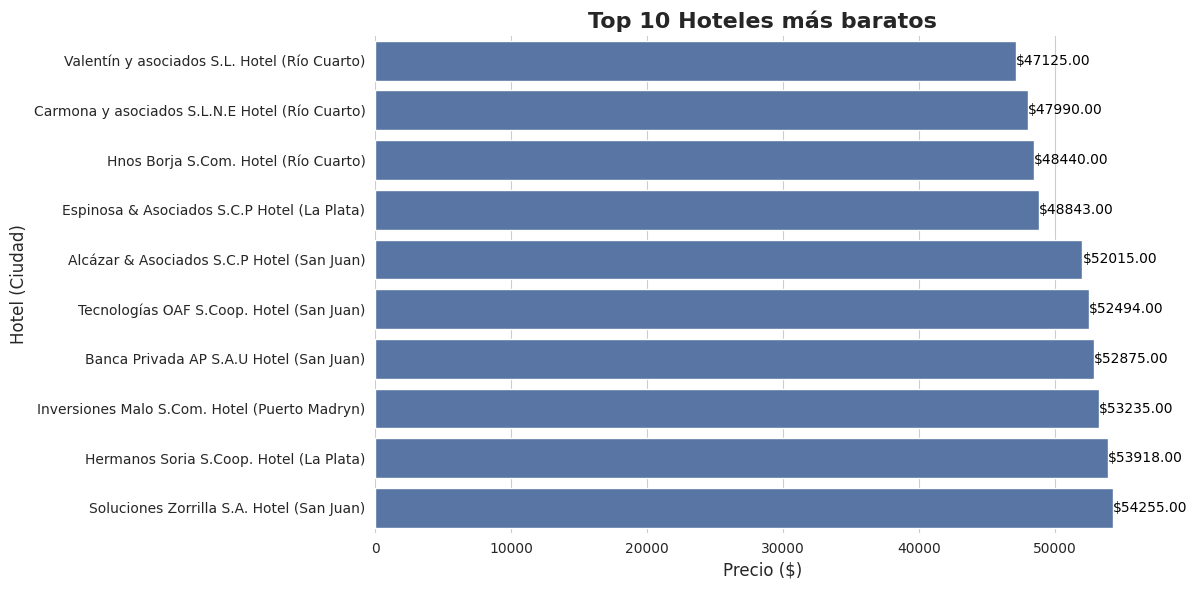

In [164]:
# Crear columna unificando Hotel y Ciudad
df["Hotel_Ciudad"] = df["Hotel"] + " (" + df["Ciudad"] + ")"

# Configuración del gráfico
plt.figure(figsize=(12, 6))  # más ancho para legibilidad
color_sns = sns.color_palette("deep")[0]

ax = sns.barplot(
    data=df,
    y="Hotel_Ciudad",
    x="Precio_minimo",
    color=color_sns
)

sns.despine(left=True, bottom=True)

# Títulos y etiquetas
plt.title("Top 10 Hoteles más baratos", fontsize=16, fontweight="bold")
plt.xlabel("Precio ($)", fontsize=12)
plt.ylabel("Hotel (Ciudad)", fontsize=12)

# Mostrar etiquetas de precio al final de cada barra
for i, v in enumerate(df["Precio_minimo"]):
    ax.text(v + 0.5, i, f"${v:.2f}", color='black', va='center', fontsize=10)

# Ajuste de layout
plt.tight_layout()
plt.show()


### III. Actividad más popular.

tipo,cantidad
relax,30
deportiva,21
cultural,21
aventura,20
gastronómica,19


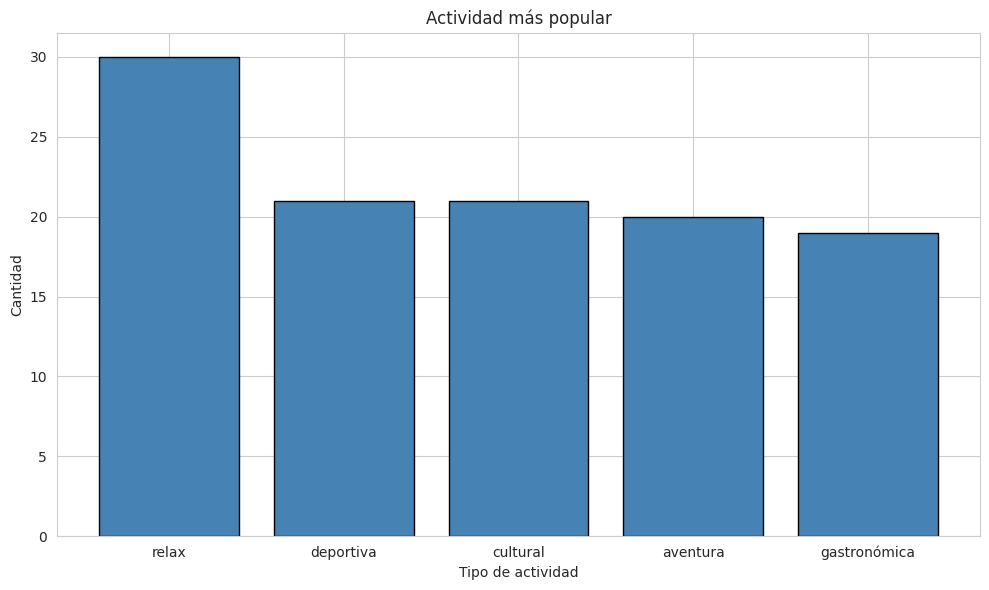

In [165]:
pipeline = [
    {"$group": {"_id":"$tipo", "cantidad": {"$sum":1}}},
    {"$project":{"_id":0,"tipo":"$_id", "cantidad": 1}},
    {"$sort": {"cantidad": -1}}
]

resultado = list(client[NOMBRE_BD_MONGO]["actividades"].aggregate(pipeline))

df = pd.DataFrame(resultado)
df = df[["tipo", "cantidad"]]
display(df.style.hide(axis="index"))

tipos=df["tipo"]
cantidades= df["cantidad"]

plt.figure(figsize=(10, 6))
plt.bar(tipos, cantidades, color="steelblue", edgecolor="black")

# Etiquetas y título
plt.xlabel("Tipo de actividad")
plt.ylabel("Cantidad")
plt.title("Actividad más popular")
plt.tight_layout()

plt.show()

## 3. Modificaciones

### A. Incrementar el precio de las actividades de Tucuman en 5% 

In [176]:
# Filtro y proyección
filtro = {"provincia": "Tucumán"}
proyeccion = {"_id": 0, "nombre": 1, "precio": 1}

# Obtener precios antes
cursor_antes = mongo.obtener_cursor(
    NOMBRE_BD_MONGO,
    nombre_coleccion=coleccion,
    filtro=filtro,
    proyeccion=proyeccion
)
df_antes = pd.DataFrame(cursor_antes)
df_antes.rename(columns={"precio": "precio_antes"}, inplace=True)

# Aumentar precio en 5%
db = mongo.client[NOMBRE_BD_MONGO]
db[coleccion].update_many(filtro, {"$mul": {"precio": 1.05}})

# Obtener precios después
cursor_despues = mongo.obtener_cursor(
    NOMBRE_BD_MONGO,
    nombre_coleccion=coleccion,
    filtro=filtro,
    proyeccion=proyeccion)

df_despues = pd.DataFrame(cursor_despues)
df_despues.rename(columns={"precio": "precio_despues"}, inplace=True)

#Uno ambos DataFrames
df_final["Aumento"] = df_final["precio_despues"] - df_final["precio_antes"]

display(df_final.style.format({
    "precio_antes": "{:.2f}",
    "precio_despues": "{:.2f}",
    "Aumento": "{:.2f}"
}).hide(axis="index"))

nombre,precio_antes,precio_despues,Aumento
Organized multimedia circuit,52097.56,54702.44,2604.88
Optional background definition,104161.61,109369.69,5208.08
Organized grid-enabled algorithm,37465.05,39338.31,1873.25


### B. Agregar al hotel id=1 el servicio de SPA 

In [177]:
# Aca usamos la funcion update_one naque hotel

resultado = client[NOMBRE_BD_MONGO].hoteles.update_one(
    {"hotel_id": 1},
    {"$addToSet": {"servicios": "wifi"}}
)

if resultado.modified_count == 0:
    print("El servicio ya existe")
else:
    print(f"Modificados: {resultado.modified_count}")

Modificados: 1


In [178]:
#Consulta para verificar que se agrego el servicio
cursor = mongo.obtener_cursor(NOMBRE_BD_MONGO,"hoteles",filtro={"hotel_id":1},proyeccion={"_id":0})
resultado = list(cursor)
resultado

[{'hotel_id': 1,
  'nombre': 'Hermanos Soria S.Coop. Hotel',
  'ciudad': 'La Plata',
  'provincia': 'Buenos Aires',
  'precio': 201178,
  'calificacion': 4,
  'servicios': ['restaurant', 'gimnasio', 'spa', 'wifi']}]

### C. Eliminar el destino que desee

In [181]:
destino_eliminar = input("Selecciona un destino a eliminar: ")

# Conectar a la base y colección
coleccion_destinos = db["destinos"]  

# Construir filtro por nombre de destino
filtro = {"ciudad": destino_eliminar}

# Eliminar documento(s) que coincidan
resultado = coleccion_destinos.delete_many(filtro)

# Mostrar mensaje
print(f"Se eliminaron {resultado.deleted_count} destino(s) con el nombre '{destino_eliminar}'")


objeto_eliminado = list(coleccion_destinos.find({"ciudad": destino_eliminar}))
if not objeto_eliminado:
    print(f"✅ El destino '{objeto_eliminado}' ya no existe en la colección.")
else:
    print(f"⚠️ Aún existen {len(objeto_eliminado)} destino(s) con ese nombre.")


Selecciona un destino a eliminar:  Bariloche


Se eliminaron 1 destino(s) con el nombre 'Bariloche'
✅ El destino '[]' ya no existe en la colección.


### D. Eliminar un usuario que desee 

In [184]:
# Pedir datos del usuario a eliminar
nombre_eliminar = input("Escriba el nombre del usuario a eliminar: ")
apellido_eliminar = input("Escriba el apellido del usuario a eliminar: ")

# Conectar a la colección de usuarios
coleccion_usuarios = db["usuarios"]

# Construir filtro por nombre y apellido
filtro = {"nombre": nombre_eliminar, "apellido": apellido_eliminar}

# Buscar si existe antes de eliminar
antes = list(coleccion_usuarios.find(filtro))
if antes:
    print(f"Se encontraron {len(antes)} usuario(s) con ese nombre y apellido:")
    for u in antes:
        print(f" - {u}")
else:
    print("No se encontró ningún usuario con ese nombre y apellido.")

# Eliminar documento(s)
resultado = coleccion_usuarios.delete_many(filtro)
print(f"\nSe eliminaron {resultado.deleted_count} usuario(s).")

# Verificar que se eliminó
despues = list(coleccion_usuarios.find(filtro))
if not despues:
    print(f"✅ El usuario '{nombre_eliminar} {apellido_eliminar}' ya no existe en la colección.")
else:
    print(f"⚠️ Aún existen {len(despues)} usuario(s) con ese nombre y apellido.")


Escriba el nombre del usuario a eliminar:  Paula
Escriba el apellido del usuario a eliminar:  Pardo


Se encontraron 1 usuario(s) con ese nombre y apellido:
 - {'_id': ObjectId('68f5a289e4a90880333c578b'), 'usuario_id': 5, 'nombre': 'Paula', 'apellido': 'Pardo', 'email': 'juliebanos@example.org', 'telefono': '+34877 41 31 64'}

Se eliminaron 1 usuario(s).
✅ El usuario 'Paula Pardo' ya no existe en la colección.


### E. Eliminar las relaciones AMIGO_DE para un usuario que quiera. 

In [ ]:
usuario_id = int(input("Ingrese el Usuario ID para borrar las relaciones AMIGO_DE: "))
eliminadas = neo4j.eliminar_amigos(usuario_id)
print(f"Se eliminaron {eliminadas} relaciones AMIGO_DE para el usuario_id: {usuario_id}")

In [ ]:
#Consulta para verificar la eliminación

query = """
MATCH (u:Usuario {usuario_id: $id})-[r:AMIGO_DE]-(amigo:Usuario)
RETURN u.usuario_id,type(r) as relacion,amigo.usuario_id
"""

resultado = neo4j.consulta(db_neo4j, query, parametros={"id": 15})
resultado